# Gut Microbiome of HIV+ Individuals in Rural Appalachia

In [1]:
!qiime info

System versions
Python version: 3.8.12
QIIME 2 release: 2021.11
QIIME 2 version: 2021.11.0
q2cli version: 2021.11.0

Installed plugins
alignment: 2021.11.0
composition: 2021.11.0
cutadapt: 2021.11.0
dada2: 2021.11.0
deblur: 2021.11.0
demux: 2021.11.0
diversity: 2021.11.0
diversity-lib: 2021.11.0
emperor: 2021.11.0
feature-classifier: 2021.11.0
feature-table: 2021.11.0
fragment-insertion: 2021.11.0
gneiss: 2021.11.0
longitudinal: 2021.11.0
metadata: 2021.11.0
phylogeny: 2021.11.0
quality-control: 2021.11.0
quality-filter: 2021.11.0
sample-classifier: 2021.11.0
taxa: 2021.11.0
types: 2021.11.0
vsearch: 2021.11.0

Application config directory
/Users/johnsterrett/mambaforge/envs/qiime2-2021.11/var/q2cli

Getting help
To get help with QIIME 2, visit https://qiime2.org


In [92]:
import os
import sys
import subprocess

from qiime2 import Artifact, Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

## Initial processing
### Unzip files

`outputs = []
for zipped in os.listdir("hiv-fastqs/"):
    bashCommand = f"unzip hiv-fastqs/{zipped} -d hiv-fastqs/"
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()
    outputs.append((output,error))
`    

`! rm hiv-fastqs/*.zip`

### Import data to qiime2 artifact

`! qiime tools import \
--type 'SampleData[PairedEndSequencesWithQuality]' \
--input-path hiv-fastqs/ \
--input-format CasavaOneEightSingleLanePerSampleDirFmt \
--output-path demux-paired-end.qza`

### Summarize the imported data

`! qiime demux summarize \
--i-data demux-paired-end.qza \
--o-visualization paired-end-summarized.qzv`

In [3]:
viz = Visualization.load("paired-end-summarized.qzv")
viz

<visualization: Visualization uuid: 93906a1a-5d08-48cc-9412-c0c4fb49e9c0>

**Thoughts** - forward

- Overall sequence quality looks awesome. 
- Looks like quality dips over the first 19 reads, which could be primers, so I'll just trim those off.
- Looks like it dips at the very end too. At bp 269, 25 percentile of PHRED is still >30, so I'll truncate there.

Trimming at 19 and 269 still gives us 250 bp - well more than we need, so that's good!

**Thoughts** - reverse
- Overall sequence quality looks good. 
- Not sure if the sequencing folks used reverse primers, so I'll trim at 19 again to be safe. Need to check in on this.
- Looks like it dips as it goes on. At bp 240, 50th percentile of PHRED starting to drop < 30, so I'll truncate there.

Trimming at 19 and 240 still gives us 221 bp - well more than we need, so that's good!

## Denoise using dada2

`! qiime dada2 denoise-paired \
--i-demultiplexed-seqs demux-paired-end.qza \
--p-trim-left-f 19 \
--p-trunc-len-f 269 \
--p-trim-left-r 19 \
--p-trunc-len-r 240 \
--output-dir dada2-out \
--verbose`

`! qiime feature-table summarize \
--i-table dada2-out/table.qza \
--m-sample-metadata-file metadata.txt \
--o-visualization dada2-out/table.qzv`

In [30]:
viz = Visualization.load("dada2-out/table.qzv")
viz

<visualization: Visualization uuid: 46b579bf-281c-4673-bf0e-88349ac5606e>

## SEPP fragment insertion for phylogenetic tree

> ! qiime fragment-insertion sepp \
--i-representative-sequences dada2-out/representative_sequences.qza \
--i-reference-database sepp-refs-silva-128.qza \
--o-tree insertion-tree.qza \
--o-placements insertion-placements.qza

> ! qiime fragment-insertion filter-features \
--i-table dada2-out/table.qza \
--i-tree insertion-tree.qza \
--o-filtered-table filtered-table.qza \
--o-removed-table removed-table.qza

## Assigning taxonomy

> ! qiime feature-classifier classify-sklearn \
--i-reads dada2-out/representative_sequences.qza \
--i-classifier silva-138-99-515-806-nb-classifier.qza \
--output-dir silva-classified

> ! qiime metadata tabulate \
--m-input-file silva-classified/classification.qza \
--o-visualization silva-classified/classification.qzv

>! mv silva-classified/classification.qza taxonomy-silva.qza 

>! mv silva-classified/classification.qzv taxonomy-silva.qzv

In [22]:
viz = Visualization.load('taxonomy-silva.qzv')
viz

<visualization: Visualization uuid: dd486f8b-be31-4bbc-a3f9-83eab4508284>

## Filter mitochondria and chloroplast

>! qiime taxa filter-table \
  --i-table filtered-table.qza \
  --i-taxonomy taxonomy-silva.qza \
  --p-exclude mitochondria,chloroplast \
  --o-filtered-table noMito_noChloro-filtered-table.qza 

In [29]:
dada2_table = Artifact.load('dada2-out/table.qza')
filtered_table = Artifact.load('filtered-table.qza')
no_M_C_table = Artifact.load('noMito_noChloro-filtered-table.qza')

df_tab = dada2_table.view(pd.DataFrame)
df_filt = filtered_table.view(pd.DataFrame)
df_MC = no_M_C_table.view(pd.DataFrame)

tables = ['df_tab', 'df_filt', 'df_MC']


total_frequencies = {x: globals()[x].values.sum() for x in tables}


print('filtered by sepp: {}'.format(total_frequencies['df_tab']-total_frequencies['df_filt']))
print('filtered by Mito/Chloro: {}'.format(total_frequencies['df_filt']-total_frequencies['df_MC']))

filtered by sepp: 0.0
filtered by Mito/Chloro: 256.0


## Taxa barplot

>! qiime taxa barplot \
--i-table noMito_noChloro-filtered-table.qza \
--i-taxonomy taxonomy-silva.qza \
--m-metadata-file metadata.txt \
--o-visualization taxa-barplot.qzv

In [25]:
viz = Visualization.load("taxa-barplot.qzv")
viz

<visualization: Visualization uuid: 62bb5b5c-f10a-4c3d-aea2-c7ed6a71db4e>

## Diversity testing

### Core metrics

>! qiime diversity core-metrics-phylogenetic \
  --i-phylogeny insertion-tree.qza \
  --i-table noMito_noChloro-filtered-table.qza \
  --p-sampling-depth 52495 \
  --m-metadata-file metadata.txt \
  --output-dir core-diversity-results

### Rarefaction

>! qiime diversity alpha-rarefaction \
  --i-table noMito_noChloro-filtered-table.qza \
  --i-phylogeny insertion-tree.qza \
  --p-max-depth 80000 \
  --o-visualization core-diversity-results/alpha-rarefaction.qzv

In [33]:
viz = Visualization.load('core-diversity-results/alpha-rarefaction.qzv')
viz

<visualization: Visualization uuid: 40c7a712-1c89-4a11-81ba-5dd737a02ef9>

### Alpha diversity statistical testing

>! qiime diversity alpha-group-significance \
--i-alpha-diversity core-diversity-results/faith_pd_vector.qza \
--m-metadata-file metadata.txt \
--o-visualization core-diversity-results/faith-pd-group-significance.qzv

>! qiime diversity alpha-correlation \
--i-alpha-diversity core-diversity-results/faith_pd_vector.qza \
--m-metadata-file metadata.txt \
--o-visualization core-diversity-results/faith-pd-correlation.qzv

In [44]:
viz = Visualization.load("core-diversity-results/faith-pd-group-significance.qzv")
viz

<visualization: Visualization uuid: a47458d4-37d1-4097-9e75-a2bf99b65519>

In [43]:
viz = Visualization.load("core-diversity-results/faith-pd-correlation.qzv")
viz

<visualization: Visualization uuid: 182ff713-52c4-4f2c-8556-a4060f5d79be>

### Beta diversity statistical testing 

>! qiime diversity beta-group-significance \
--i-distance-matrix core-diversity-results/unweighted_unifrac_distance_matrix.qza \
--m-metadata-file metadata.txt \
--m-metadata-column HIV \
--o-visualization core-diversity-results/unweighted-unifrac-HIV-significance.qzv \
--p-pairwise

In [49]:
viz = Visualization.load("core-diversity-results/unweighted-unifrac-HIV-significance.qzv")
viz

<visualization: Visualization uuid: 1076ef73-3491-498f-bf6d-365ada923a96>

## Differential abundance

>! qiime taxa collapse \
--i-table core-diversity-results/rarefied_table.qza \
--i-taxonomy taxonomy-silva.qza --p-level 2 \
--o-collapsed-table core-diversity-results/phylum-rarefied_table.qza

>! qiime composition add-pseudocount \
--i-table core-diversity-results/phylum-rarefied_table.qza \
--o-composition-table core-diversity-results/phylum-pseudo-rarefied_table.qza

>! qiime composition ancom \
--i-table core-diversity-results/phylum-pseudo-rarefied_table.qza \
--m-metadata-file metadata.txt \
--m-metadata-column HIV \
--o-visualization core-diversity-results/ancom-phylum-HIV.qzv

In [65]:
viz = Visualization.load("core-diversity-results/ancom-phylum-HIV.qzv")
viz

<visualization: Visualization uuid: a078ccb6-9d82-497c-acd1-93499450193b>

In [104]:
data = Artifact.load("core-diversity-results/phylum-rarefied_table.qza").view(pd.DataFrame)

#convert to relative abundances
data_mat = np.matrix(data)
data_mat /= np.sum(data_mat, axis=1)
data = pd.DataFrame(data_mat, index=data.index, columns=data.columns)

metadata = pd.read_csv("metadata.txt", sep="\t", index_col="SampleID")

Currently missing H19-10

In [105]:
metadata = metadata.loc[data.index]

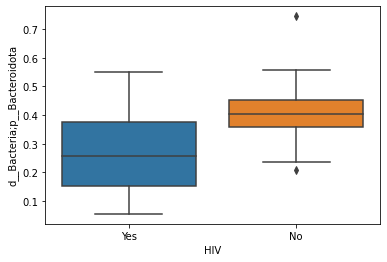

In [109]:
sns.boxplot(x=metadata["HIV"],
            y=data["d__Bacteria;p__Bacteroidota"])
plt.show()

## Create a L7 tax table for future use

>! qiime taxa collapse \
--i-table noMito_noChloro-filtered-table.qza \
--i-taxonomy taxonomy-silva.qza --p-level 7 \
--o-collapsed-table tax_table.qza